# Neural Nets: The Devil's in the Details

Seth Weidman    

06/02/2017

# Neural Nets: WTF is going on??

<img src='neural_net_wtf.png' height=200>

What does this actually mean?

## Review from last time (Pt. 1)

* Neural nets are nested functions, where the functions applied to the inputs alternate between two types:
    * Linear functions, represented by matrix multiplications
    * Non linear "activation" functions
* Because they are functions, we can represent the neural net making a prediction mathematically. For example, if $X$ is the input, then the prediction $P$ is just: 

$$ P = A(B(C(D(X, V)), W)) $$

where $A$, $B$, $C$, and $D$ are functions and $V$ and $W$ are weight matrices.

## Review from last time (Pt. 2)

* This prediction is compared to the actual value we were trying to predict, $Y$, and a loss is computed, for example:

$$ L = (Y - P) ^ 2 $$

* And then the weights are adjusted so that this loss will be reduced:

$$ W - \frac{\partial L}{\partial W}$$

$$ V - \frac{\partial L}{\partial V}$$

## Key point from last time

* This process - of computing derivatives to continually update the weights in a neural net - works because of **the chain rule from calculus**.

## We can do basic neural nets!

<img src="neural_net_check.png" height=200>

# This basic neural net framework can learn MNIST

**This basic neural net framework can learn MNIST**

## Pt. 1: Imports

In [128]:
# Imports

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_mldata
import numpy as np
from sklearn.model_selection import train_test_split

**This basic neural net framework can learn MNIST**

## Pt. 2: Read in the MNIST Data

In [129]:
## Read in the MNIST Data

mnist = fetch_mldata('MNIST original')

In [130]:
def get_mnist_X_Y(mnist):
    data = mnist.data
    X = (data - data.min()) * 1.0 / (data.max() - data.min())
    target = mnist.target
    Y = np.zeros((len(target), 10))
    for i in range(len(target)):
        Y[i][int(target[i])] = 1 
    print("Number of images: ", X.shape[0])
    return X, Y

In [131]:
X, Y = get_mnist_X_Y(mnist)

Number of images:  70000


In [132]:
train_prop = 0.9
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, 
    test_size=1-train_prop, 
    random_state=1)

**This basic neural net framework can learn MNIST**

## Pt. 3: Visualize the Images

In [133]:
def visualize_image(index):
    target = mnist.target
    print("Label: ", int(target[index]))
    plt.imshow(1.0 - X[index].reshape(28,28), cmap='gray')
    plt.show() 

Label:  0


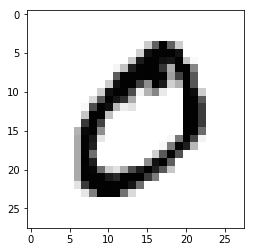

In [134]:
visualize_image(0)

**This basic neural net framework can learn MNIST**

## Pt. 4: Train the neural net

In [135]:
def _sigmoid(x):
    return 1.0/(1.0+np.exp(-x))

In [136]:
def learn(X, Y, num_iter):
    np.random.seed(2)
    V = np.random.randn(784, 50)
    W = np.random.randn(50, 10)
    for j in range(num_iter):
        i = np.random.randint(0, num_iter)
        x = np.array(X[i], ndmin=2)
        y = np.array(Y[i], ndmin=2)
        A = np.dot(x,V)
        B = _sigmoid(A)
        C = np.dot(B,W)
        P = _sigmoid(C)
        sum_P = np.sum(P)
        L = 0.5 * (y - P) ** 2
        dLdP = -1.0 * (y-P)
        dPdC = _sigmoid(C) * (1-_sigmoid(C))
        dLdC = dLdP * dPdC
        dCdW = B.T
        dLdW = np.dot(dCdW, dLdC)
        dCdB = W.T
        dLdB = np.dot(dLdC, dCdB)
        dBdA = _sigmoid(A) * (1-_sigmoid(A))
        dLdA = dLdB * dBdA
        dAdV = x.T
        dLdV = np.dot(dAdV, dLdA)
        W -= dLdW
        V -= dLdV
    return V, W  

In [137]:
def predict(X, V, W):
    A = np.dot(X,V)
    B = _sigmoid(A)
    C = np.dot(B,W)
    P = _sigmoid(C)
    return P

In [138]:
V, W = learn(X_train, Y_train, num_iter=X_train.shape[0])
P = predict(X_test, V, W)

In [139]:
preds = [np.argmax(x) for x in P]
actuals = [np.argmax(x) for x in Y_test]

accuracy = sum(np.array(preds) == np.array(actuals)) * 1.0 / len(preds)
print("Neural Net MNIST Classification Accuracy:", round(accuracy, 3) * 100, "percent")

Neural Net MNIST Classification Accuracy: 91.3 percent


Good...

...but not optimal: [see here](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html)

<img src='MNIST_performance.png' height=200>

# How can we do better?

Our options include:

* Building deeper nets
* Changing "learning rates" / using "learning rate decay"
* Changing "weight initialization"
* Adding "dropout"
* ...and that doesn't even cover many of the cutting edge techniques listed above

Are you overwhelmed yet?

## Paradox of choice

<img src="supermarket.png">

Neural nets are really hard to unpack and understand - so much so that a lot of people don't even try.

**By "playing with these knobs" individually - as well as learning a bit of theory, we can "peek under the hood" and understand how neural nets are working.**

# Multiple hidden layers ("Deep Learning")

**"What I cannot build, I cannot understand."**

--Richard Feynman

## Before:

With a neural net with one hidden layer, one pass through was 25 manually coded steps. 

_This will quickly get unweildy if we add more hidden layers._

## New understanding: "Layers"

No longer will we think of neural nets as complicated mathematical functions like $ P = A(B(C(D(X, V)), W)) $.

### New understanding: "Layers"

Instead, we'll think of them as a series of layers:

<img src='neural_net_layers.png' height=200>

## Coding the new neural network, layers

We'll define a `NeuralNetwork` class that defines a neural network as a series of `Layers`:

In [338]:
class NeuralNetwork:
    def __init__(self, layers, random_seed):
        self.layers = layers
        self.random_seed = random_seed
        for i, layer in enumerate(self.layers):
            setattr(layer, 'random_seed', self.random_seed+i)
            layer.initialize_weights()


    def forwardpass(self, X):
        """ Calculate an output Y for the given input X. """
        X_next = X
        for layer in self.layers:
            X_next = layer.fprop(X_next)
        prediction = X_next
        return prediction

    def loss(self, prediction, Y):
        """ Calculate error on the given data. """
        loss = 0.5 * (Y - prediction) ** 2
        return -1.0 * (Y - prediction)

    def backpropogate(self, loss):
        """ Calculate an output Y for the given input X. """
        loss_next = loss
        for layer in reversed(self.layers):
            loss_next = layer.bprop(loss_next)
        return loss

### Coding the new neural network, layers

In [351]:
class Layer(object):
    def _setup(self, input_shape):
        """ Setup layer with parameters that are unknown at __init__(). """
        pass

    def fprop(self, input):
        """ Calculate layer output for given input (forward propagation). """
        raise NotImplementedError()

    def bprop(self, output_grad):
        """ Calculate input gradient. """
        raise NotImplementedError()

### Coding the new neural network, layers

In [352]:
class Linear(Layer):
    
    random_seed = None
    
    def __init__(self, n_in, n_out, 
                 activation_function):
        self.n_in = n_in
        self.n_out = n_out        
        self.iteration = None
        self.activation_function = activation_function

    def initialize_weights(self):
        np.random.seed(seed=self.random_seed)
        self.W = np.random.normal(size=(self.n_in, self.n_out))

    def fprop(self, layer_input):
        self.layer_input = layer_input
        self.activation_input = np.dot(layer_input, self.W)
        return self.activation_function(self.activation_input, bprop=False)

    def bprop(self, layer_gradient):
        dOutdActivationInput = self.activation_function(self.activation_input, bprop=True)
        dLayerInputdActivationInput = layer_gradient * dOutdActivationInput
        dActivationOutputdActivationInput = self.layer_input.T
        output_grad = np.dot(dLayerInputdActivationInput, self.W.T)
        W_new = self.W - np.dot(dActivationOutputdActivationInput, dLayerInputdActivationInput)
        self.W = W_new
        return output_grad
    

### Coding the new neural network, layers - and don't forget about that activation function!

In [343]:
def sigmoid(x, bprop=False):
    if bprop:
        s = sigmoid(x)
        return s*(1-s)
    else:
        return 1.0/(1.0+np.exp(-x))

## Running this neural network:

In [344]:
layer1 = Linear(n_in=784, n_out=50, activation_function=sigmoid)
layer2 = Linear(n_in=50, n_out=10, activation_function=sigmoid)

In [345]:
nn_mnist = NeuralNetwork(
    layers=[layer1, layer2],
    random_seed=2)


In [346]:
def neural_net_pass(net, x, y):
    pred = net.forwardpass(x)
    loss = net.loss(pred, y)
    net.backpropogate(loss)
    return pred

### Running this neural network

In [353]:
# Randomly shuffle the indices of the points in the training set:
np.random.seed(4)
data_size = X.shape[0]
train_size = int(train_prop * data_size)
indices = list(range(train_size))
np.random.shuffle(indices)

In [ ]:
# Loop through every element in the training set: 
for index in indices:
    x = np.array(X_train[index], ndmin=2)
    y = np.array(Y_train[index], ndmin=2)
    neural_net_pass(nn_mnist, x, y)

In [ ]:
P = nn_mnist.forwardpass(X_test)
preds = [np.argmax(x) for x in P]
actuals = [np.argmax(x) for x in Y_test]

accuracy = sum(np.array(preds) == np.array(actuals)) * 1.0 / len(preds)
print("Neural Net MNIST Classification Accuracy:", round(accuracy, 3) * 100, "percent")

# Learning rate momentum

# Weight initialization

# Batch normalization

# Dropout